<a href="https://colab.research.google.com/github/NosenkoArtem/MADMO-advanced-/blob/master/week_3/%5Bseminar%5D_convnet_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Рассмотрим сравнение сверточной сети и многослойной полносвязной для классификации MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Dataset (MNIST)


We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [ ]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


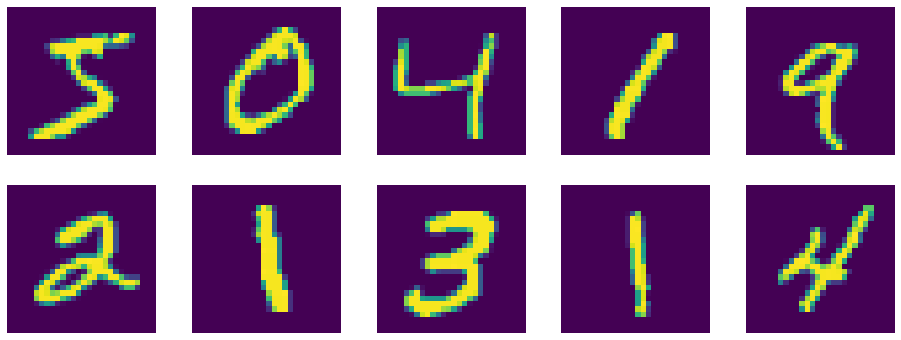

In [ ]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Create the model classes

In [ ]:
! python --version

Python 3.6.9


In [ ]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
                      nn.Linear(input_size, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, output_size),
                      nn.LogSoftmax(dim=-1)
                      )

    def forward(self, x):
        x =  x.view(-1, self.input_size) 
        return self.network(x)
    

class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.output_size = output_size
        hidden_size = 25
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=n_feature, 
                               kernel_size=5)
        
        self.conv2 = nn.Conv2d(in_channels=n_feature, 
                               out_channels=n_feature, 
                               kernel_size=5)
        self.fc1 = nn.Linear(16*self.n_feature, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        ###
        x = x.view(-1, 16*self.n_feature) 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [ ]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        # TRAIN
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        # model.fc1.weights.data.grad 
        # w = w_prev + alpha* w_prev.grad
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()                                                           
        pred = output.data.max(-1, keepdim=True)[1]                                                                
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [ ]:
n_hidden = 8 # number of hidden units
input_size = 784 
output_size = 10
model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.9)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))
max_epochs = 1
for epoch in range(0, max_epochs):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.296322
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.068933
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.763508
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.497936
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.656341
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.334151
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.213632
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.327624
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.332045
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.461046

Test set: Average loss: 0.3278, Accuracy: 9003/10000 (90%)



# Train a ConvNet with the same number of parameters

In [ ]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.9)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))
max_epochs = 1

for epoch in range(0, max_epochs):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 3747
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.281399
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.177309
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.181595
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.126851
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.168177
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.224233
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.290233
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.120141
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.132622
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.043675

Test set: Average loss: 0.0973, Accuracy: 9701/10000 (97%)



# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images
Благодаря использованию сверточных сетей мы получаем качество значительно лучше, но почему это происходит? Мы изначально заложили в свертки гипотезу о локльности (схожие пиксели находятся рядом друг с другом)

# Эксперимент: что если эта гипотеза не выполняется? 


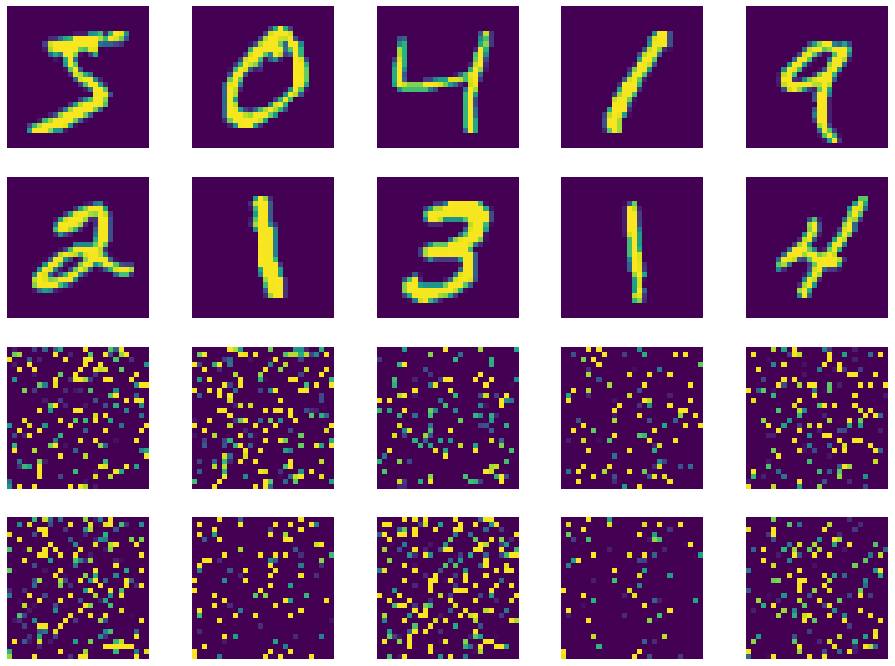

In [ ]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet with permuted pixels

In [ ]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.9)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 3747
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.322115
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.791798
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.785743
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.535913
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.490981
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.359948
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.460851
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.458110
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.287113
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.570355

Test set: Average loss: 0.3952, Accuracy: 8741/10000 (87%)



# Fully-Connected with Permuted Pixels

In [ ]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.9)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.290786
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.805057
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.380964
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.610801
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.256358
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.298062
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.544561
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.267591
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.521520
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.578244

Test set: Average loss: 0.3536, Accuracy: 8929/10000 (89%)



### The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

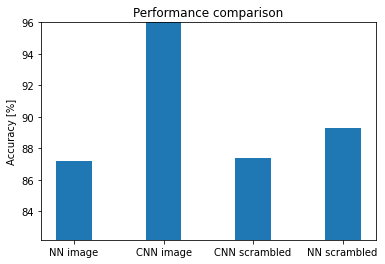

In [ ]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.title('Performance comparison');